# Imports

In [64]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
import string

from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE

In [2]:
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Embedding, Activation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

In [3]:
from tensorflow.keras.utils import to_categorical

# Dataframe Initialization and Observations

In [4]:
# load data and initialize dataframe
df = pd.read_csv('./data/judge-1377884607_tweet_product_company.csv',
                 encoding="ISO-8859-1")
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [5]:
# check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
# count nulls
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [7]:
# view nulls vs subcategories
df['emotion_in_tweet_is_directed_at'].value_counts(dropna=False)

NaN                                5802
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [8]:
df['unprocessed_text'] = df['tweet_text'].str.split()
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,unprocessed_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[.@wesley83, I, have, a, 3G, iPhone., After, 3..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[@jessedee, Know, about, @fludapp, ?, Awesome,..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[@swonderlin, Can, not, wait, for, #iPad, 2, a..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[@sxsw, I, hope, this, year's, festival, isn't..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[@sxtxstate, great, stuff, on, Fri, #SXSW:, Ma..."
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,"[Ipad, everywhere., #SXSW, {link}]"
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,"[Wave,, buzz..., RT, @mention, We, interrupt, ..."
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,"[Google's, Zeiger,, a, physician, never, repor..."
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,"[Some, Verizon, iPhone, customers, complained,..."


### Summary

We have a large number of nulls in the data set. We will need to figure out how to handle these nulls in data cleaning in addition to the standard NLP data cleaning procedures such as RegEx, stopword removal, lemmatization,  and tokenization. 

# Data Cleanup

In [9]:
def process_string(text):
    """This function returns a processed list of words from the given text
    
    This function removes html elements and urls using regular expression, then
    converts string to list of workds, them find the stem of words in the list of words and
    finally removes stopwords and punctuation marks from list of words.
    
    Args:
        text(string): The text from which html elements, urls, stopwords, punctuation are removed and lemmatized
        
    Returns:
        clean_text(string): A text formed after text preprocessing.
    """
    # Remove twitter user handle from the text
    text = re.sub('@[^\s]+',
                  '',
                  str(text))
    
    
    # Remove any urls from the text
    text = re.sub(r'https:\/\/.*[\r\n]*',
                  "",
                  str(text))
    
    # Remove any urls starting from www. in the text
    text = re.sub(r'www\.\w*\.\w\w\w',
                  "",
                  str(text))
    
    # Remove any html elements from the text
    text = re.sub(r"<[\w]*[\s]*/>",
                  "",
                  str(text))
    
    # Remove prediods  marks
    text = re.sub(r"[\.]*",
                  "",
                  str(text))
    
   

    
 
    # Initialize RegexpTokenizer
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenizer = RegexpTokenizer(pattern)

    
    # Tokenize text
    text_tokens = tokenizer.tokenize(text.lower())
    
    lemmatizer  = WordNetLemmatizer()
    # Get english stopwords
    english_stopwords = stopwords.words("english")
    new_list = ["mention", "sxsw", 'link', 'rt', 'quot', '@*']
    english_stopwords.extend(new_list)
    
    cleaned_text_tokens = [] # A list to hold cleaned text tokens
    
    for word in text_tokens:
        if((word not in english_stopwords) and # Remove stopwords
            (word not in string.punctuation)): # Remove punctuation marks
                
                lemmas = lemmatizer.lemmatize(word) # Get lemma of the current word
                cleaned_text_tokens.append(lemmas) # Appened lemma word to list of cleaned list
    
    # Combine list into single string
    clean_text = " ".join(cleaned_text_tokens)
    
    return clean_text

In [10]:
# apply cleanup function to tweet_text column
df['tweet_text'] = df['tweet_text'].apply(process_string)

In [11]:
df['processed_text'] = df['tweet_text'].str.split()

In [12]:
# categorize Tweets by 'Manufacturer' based on if Tweet contains certain keywords words
# instantiate list of keywords
is_apple = ['ipad', 
            "ipad's", 
            'iphone', 
            'iphones', 
            "iphone's", 
            'apple', 
            "apple's", 
            'mac', 
            'macos' 
            'ios', 
            'os' 
            'macbook', 
            'macbook pro', 
            'm1', 
            'macbook air',
            'air',
            'airpod', 
            'airpods',
            'airtag'
            'watch'
            'monterey',
            'big sur',
            'catalina',
            'mojave',
            'high sierra',
            'sierra',
            'el capitan',
            'yosemite',
            'icloud']

is_google = ['windows', 
             'google', 
             "google's", 
             'googles' 
             'pixel', 
             "pixel's", 
             'pixels', 
             'android', 
             "android's", 
             "androids", 
             'nest']

In [13]:
# define functions that loop through keyword lists and assign a category in a new column in the df
def apple_sorter(x):
    for i in is_apple:
        if i.lower() in x.lower():
            return 'Apple'
        else:
            continue
        
def google_sorter(x):
    for i in is_google:
        if i.lower() in x.lower():
            return 'Google'
        else:
            continue

In [14]:
# defining dictionary map and mapping
driver_operator_map = {
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPhone': 'Apple',
    'Other Apple product or service1': 'Apple',
    
    'Google': 'Google',
    'Other Google product or service': 'Google',
    'Android App': 'Google',
    'Android': 'Google'}

df['Manufacturer'] = df['emotion_in_tweet_is_directed_at'].map(driver_operator_map)
df['Manufacturer'].value_counts(dropna=False)

NaN       5837
Apple     2374
Google     882
Name: Manufacturer, dtype: int64

In [15]:
# apply apple and google sorters to tweet_text
df['Manufacturer'] = df['tweet_text'].apply(apple_sorter)
df['Google'] = df['tweet_text'].apply(google_sorter)

In [16]:
# merge created columns into 1 master column, 'Manufacturer'
df['Manufacturer'] = df['Manufacturer'].combine_first(df['Google'])

In [17]:
# drop extraneous columns
df.drop('Google', axis=1, inplace=True)
df.drop('emotion_in_tweet_is_directed_at', axis=1, inplace=True)

In [18]:
# recheck null counts
df['Manufacturer'].value_counts(dropna=False)

Apple     5577
Google    2749
NaN        767
Name: Manufacturer, dtype: int64

In [19]:
df.isnull().sum()

tweet_text                                              0
is_there_an_emotion_directed_at_a_brand_or_product      0
unprocessed_text                                        1
processed_text                                          0
Manufacturer                                          767
dtype: int64

In [20]:
# # drop remaining NaN - does not contain major keywords related to Apple and Google
# df.dropna(inplace=True)

In [21]:
# # recheck null counts
# df.isnull().sum()

In [22]:
# # recheck null counts
# df['Manufacturer'].value_counts(dropna=False)

In [23]:
# check cleaned data
df.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product,unprocessed_text,processed_text,Manufacturer
0,g iphone hr tweeting rise austin dead need upg...,Negative emotion,"[.@wesley83, I, have, a, 3G, iPhone., After, 3...","[g, iphone, hr, tweeting, rise, austin, dead, ...",Apple
1,know awesome ipad iphone app likely appreciate...,Positive emotion,"[@jessedee, Know, about, @fludapp, ?, Awesome,...","[know, awesome, ipad, iphone, app, likely, app...",Apple
2,wait ipad also sale,Positive emotion,"[@swonderlin, Can, not, wait, for, #iPad, 2, a...","[wait, ipad, also, sale]",Apple
3,hope year's festival crashy year's iphone app,Negative emotion,"[@sxsw, I, hope, this, year's, festival, isn't...","[hope, year's, festival, crashy, year's, iphon...",Apple
4,great stuff fri marissa mayer google tim o'rei...,Positive emotion,"[@sxtxstate, great, stuff, on, Fri, #SXSW:, Ma...","[great, stuff, fri, marissa, mayer, google, ti...",Google


In [24]:
# rename columns
df.rename(columns={'tweet_text':'Text', 'is_there_an_emotion_directed_at_a_brand_or_product' : 'Sentiment'}, inplace=True)

In [25]:
# quick check
df.head()

,Text,Sentiment,unprocessed_text,processed_text,Manufacturer
0,g iphone hr tweeting rise austin dead need upg...,Negative emotion,"[.@wesley83, I, have, a, 3G, iPhone., After, 3...","[g, iphone, hr, tweeting, rise, austin, dead, ...",Apple
1,know awesome ipad iphone app likely appreciate...,Positive emotion,"[@jessedee, Know, about, @fludapp, ?, Awesome,...","[know, awesome, ipad, iphone, app, likely, app...",Apple
2,wait ipad also sale,Positive emotion,"[@swonderlin, Can, not, wait, for, #iPad, 2, a...","[wait, ipad, also, sale]",Apple
3,hope year's festival crashy year's iphone app,Negative emotion,"[@sxsw, I, hope, this, year's, festival, isn't...","[hope, year's, festival, crashy, year's, iphon...",Apple
4,great stuff fri marissa mayer google tim o'rei...,Positive emotion,"[@sxtxstate, great, stuff, on, Fri, #SXSW:, Ma...","[great, stuff, fri, marissa, mayer, google, ti...",Google


In [26]:
# check value counts for Sentiment column
df['Sentiment'].value_counts(dropna=False)

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: Sentiment, dtype: int64

In [27]:
# drop 'I can't tell' as this will not be relevant for modeling
df = df[df['Sentiment'] != "I can't tell"]

In [28]:
# final check
df['Sentiment'].value_counts(normalize=True)

No emotion toward brand or product    0.602999
Positive emotion                      0.333221
Negative emotion                      0.063780
Name: Sentiment, dtype: float64

In [29]:
df

,Text,Sentiment,unprocessed_text,processed_text,Manufacturer
0,g iphone hr tweeting rise austin dead need upg...,Negative emotion,"[.@wesley83, I, have, a, 3G, iPhone., After, 3...","[g, iphone, hr, tweeting, rise, austin, dead, ...",Apple
1,know awesome ipad iphone app likely appreciate...,Positive emotion,"[@jessedee, Know, about, @fludapp, ?, Awesome,...","[know, awesome, ipad, iphone, app, likely, app...",Apple
2,wait ipad also sale,Positive emotion,"[@swonderlin, Can, not, wait, for, #iPad, 2, a...","[wait, ipad, also, sale]",Apple
3,hope year's festival crashy year's iphone app,Negative emotion,"[@sxsw, I, hope, this, year's, festival, isn't...","[hope, year's, festival, crashy, year's, iphon...",Apple
4,great stuff fri marissa mayer google tim o'rei...,Positive emotion,"[@sxtxstate, great, stuff, on, Fri, #SXSW:, Ma...","[great, stuff, fri, marissa, mayer, google, ti...",Google
...,...,...,...,...,...
9088,ipad everywhere,Positive emotion,"[Ipad, everywhere., #SXSW, {link}]","[ipad, everywhere]",Apple
9089,wave buzz interrupt regularly scheduled geek p...,No emotion toward brand or product,"[Wave,, buzz..., RT, @mention, We, interrupt, ...","[wave, buzz, interrupt, regularly, scheduled, ...",Google
9090,google's zeiger physician never reported poten...,No emotion toward brand or product,"[Google's, Zeiger,, a, physician, never, repor...","[google's, zeiger, physician, never, reported,...",Google
9091,verizon iphone customer complained time fell b...,No emotion toward brand or product,"[Some, Verizon, iPhone, customers, complained,...","[verizon, iphone, customer, complained, time, ...",Apple


In [30]:
df.drop(index=df.index[-1],
        axis=0,
        inplace=True)

df.tail()

,Text,Sentiment,unprocessed_text,processed_text,Manufacturer
9087,yup third app yet i'm android suggestion cc,No emotion toward brand or product,"[@mention, Yup,, but, I, don't, have, a, third...","[yup, third, app, yet, i'm, android, suggestio...",Google
9088,ipad everywhere,Positive emotion,"[Ipad, everywhere., #SXSW, {link}]","[ipad, everywhere]",Apple
9089,wave buzz interrupt regularly scheduled geek p...,No emotion toward brand or product,"[Wave,, buzz..., RT, @mention, We, interrupt, ...","[wave, buzz, interrupt, regularly, scheduled, ...",Google
9090,google's zeiger physician never reported poten...,No emotion toward brand or product,"[Google's, Zeiger,, a, physician, never, repor...","[google's, zeiger, physician, never, reported,...",Google
9091,verizon iphone customer complained time fell b...,No emotion toward brand or product,"[Some, Verizon, iPhone, customers, complained,...","[verizon, iphone, customer, complained, time, ...",Apple


In [31]:
# np.unique(df['label'], return_counts=True)

In [32]:
df = df.reset_index()

# create a new data frame with "id" and "comment" fields
df_subset = df[['index', 'Sentiment']].copy()

# data clean-up
# remove all non-aphabet characters
df_subset['Sentiment'] = df_subset['Sentiment'].str.replace("[^a-zA-Z#]", " ")

# covert to lower-case
df_subset['Sentiment'] = df_subset['Sentiment'].str.casefold()
# print (df_subset.head(10))

# set up empty dataframe for staging output
df1 = pd.DataFrame()
df1['index'] = ['99999999999']
df1['sentiment_type']='NA999NA'
df1['sentiment_score']=0

print('Processing sentiment analysis...')
sid = SentimentIntensityAnalyzer()
t_df = df1

for index, row in df_subset.iterrows():
    scores = sid.polarity_scores(row[1])

    for key, value in scores.items():
        temp = [key, value, row[0]]
        df1['index'] = row[0]
        df1['sentiment_type'] = key
        df1['sentiment_score'] = value
        t_df = t_df.append(df1)

# remove dummy row with row_id = 99999999999
t_df_cleaned = t_df[t_df.index != '99999999999']

# remove duplicates if any exist
t_df_cleaned = t_df_cleaned.drop_duplicates()

# only keep rows where sentiment_type = compound
t_df_cleaned = t_df[t_df.sentiment_type == 'compound']

# print(t_df_cleaned.head(10))

# merge dataframes
df = pd.merge(df, t_df_cleaned, on='index', how='inner')

df.head()

Processing sentiment analysis...


,index,Text,Sentiment,unprocessed_text,processed_text,Manufacturer,sentiment_type,sentiment_score
0,0,g iphone hr tweeting rise austin dead need upg...,Negative emotion,"[.@wesley83, I, have, a, 3G, iPhone., After, 3...","[g, iphone, hr, tweeting, rise, austin, dead, ...",Apple,compound,-0.5719
1,1,know awesome ipad iphone app likely appreciate...,Positive emotion,"[@jessedee, Know, about, @fludapp, ?, Awesome,...","[know, awesome, ipad, iphone, app, likely, app...",Apple,compound,0.5574
2,2,wait ipad also sale,Positive emotion,"[@swonderlin, Can, not, wait, for, #iPad, 2, a...","[wait, ipad, also, sale]",Apple,compound,0.5574
3,3,hope year's festival crashy year's iphone app,Negative emotion,"[@sxsw, I, hope, this, year's, festival, isn't...","[hope, year's, festival, crashy, year's, iphon...",Apple,compound,-0.5719
4,4,great stuff fri marissa mayer google tim o'rei...,Positive emotion,"[@sxtxstate, great, stuff, on, Fri, #SXSW:, Ma...","[great, stuff, fri, marissa, mayer, google, ti...",Google,compound,0.5574


In [33]:
df['preprocessed_text'] = df['Text'].str.split()

In [34]:
df['length_tweet'] = df['Text'].str.len()

In [35]:
label_encoder = preprocessing.LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])
df.head()

,index,Text,Sentiment,unprocessed_text,processed_text,Manufacturer,sentiment_type,sentiment_score,preprocessed_text,length_tweet,label
0,0,g iphone hr tweeting rise austin dead need upg...,Negative emotion,"[.@wesley83, I, have, a, 3G, iPhone., After, 3...","[g, iphone, hr, tweeting, rise, austin, dead, ...",Apple,compound,-0.5719,"[g, iphone, hr, tweeting, rise, austin, dead, ...",65,0
1,1,know awesome ipad iphone app likely appreciate...,Positive emotion,"[@jessedee, Know, about, @fludapp, ?, Awesome,...","[know, awesome, ipad, iphone, app, likely, app...",Apple,compound,0.5574,"[know, awesome, ipad, iphone, app, likely, app...",80,2
2,2,wait ipad also sale,Positive emotion,"[@swonderlin, Can, not, wait, for, #iPad, 2, a...","[wait, ipad, also, sale]",Apple,compound,0.5574,"[wait, ipad, also, sale]",19,2
3,3,hope year's festival crashy year's iphone app,Negative emotion,"[@sxsw, I, hope, this, year's, festival, isn't...","[hope, year's, festival, crashy, year's, iphon...",Apple,compound,-0.5719,"[hope, year's, festival, crashy, year's, iphon...",45,0
4,4,great stuff fri marissa mayer google tim o'rei...,Positive emotion,"[@sxtxstate, great, stuff, on, Fri, #SXSW:, Ma...","[great, stuff, fri, marissa, mayer, google, ti...",Google,compound,0.5574,"[great, stuff, fri, marissa, mayer, google, ti...",99,2


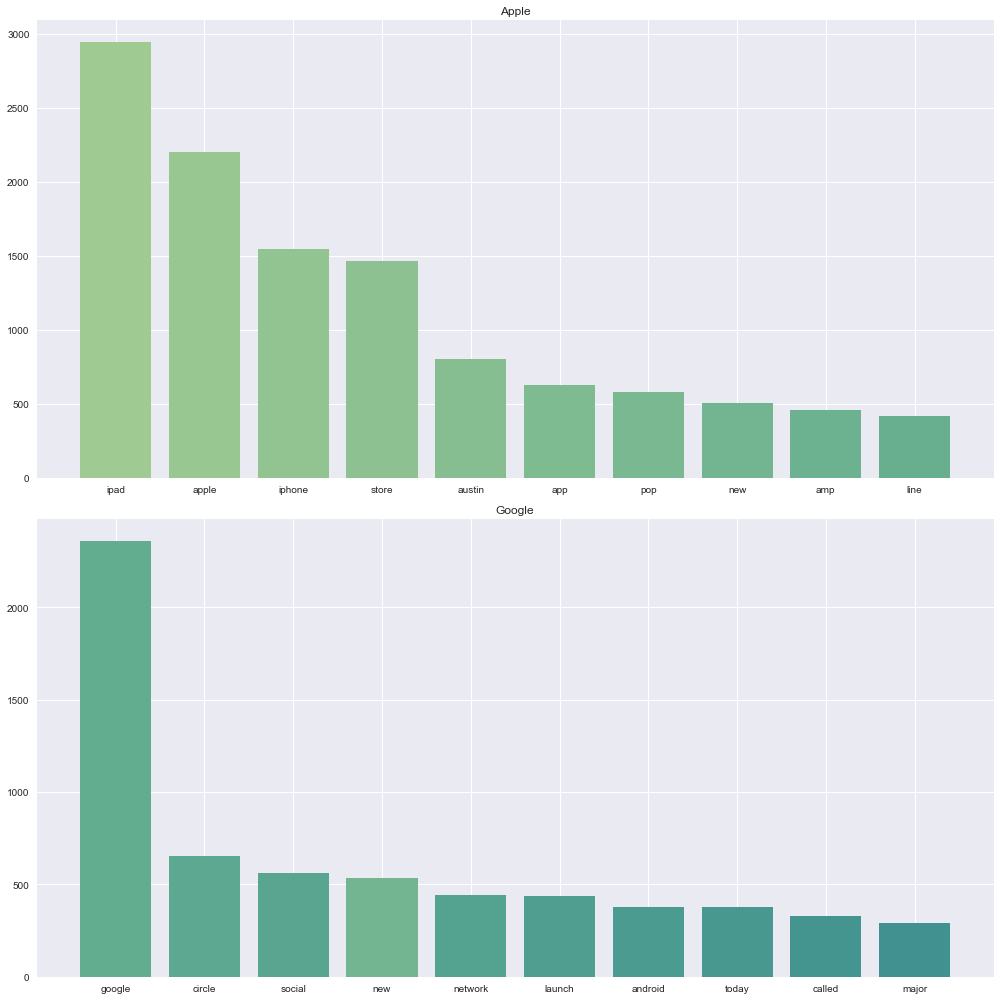

In [59]:
# Set up figure and axes
fig, axes = plt.subplots(nrows=2, figsize=(14, 14))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}

# Establish color palette to pull from
# (If you get an error message about popping from an empty list, increase this #)
color_palette = sns.color_palette('crest', n_colors=44)

# Creating a plot for each unique genre
data_by_manufacturer = [y for _, y in df.groupby('Manufacturer', as_index=False)]
for index, manufacturer_df in enumerate(data_by_manufacturer):
    
    # Find top 10 words in this genre
    all_words_in_manufacturer = manufacturer_df.preprocessed_text.explode()
    top_10 = all_words_in_manufacturer.value_counts()[:10]
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[index]
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(manufacturer_df.iloc[0].Manufacturer.title())
    
fig.tight_layout()

plt.savefig('images/apple_google_top_words.png');

In [96]:
twitter_mask = np.array(Image.open("./images/twitter_mask.png"))
twitter_mask

array([[[  2,   2,   2, 110],
        [180, 180, 180, 238],
        [253, 253, 253, 255],
        ...,
        [250, 250, 250, 255],
        [158, 158, 158, 233],
        [  2,   2,   2, 110]],

       [[180, 180, 180, 238],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [158, 158, 158, 233]],

       [[253, 253, 253, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [250, 250, 250, 255]],

       ...,

       [[250, 250, 250, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [250, 250, 250, 255]],

       [[158, 158, 158, 233],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [158, 158, 158, 233]],

       [[  2

In [97]:
# creating a word cloud image with a twitter mask
english_stopwords = stopwords.words("english")
new_list = ["mention", "sxsw", 'link', 'rt', 'quot']
english_stopwords.extend(new_list)

In [98]:
# creating a corpus for positive tweets only 
apple = df[df.Manufacturer == "Apple"]
apple_corpus = apple.Text.to_list()
apple_corpus = ",".join(apple_corpus)

In [99]:
# word tokenize and lowercase all words 
apple_tokens = word_tokenize(apple_corpus)
apple_stopped = [token.lower() for token in apple_tokens if token.lower() not in english_stopwords]

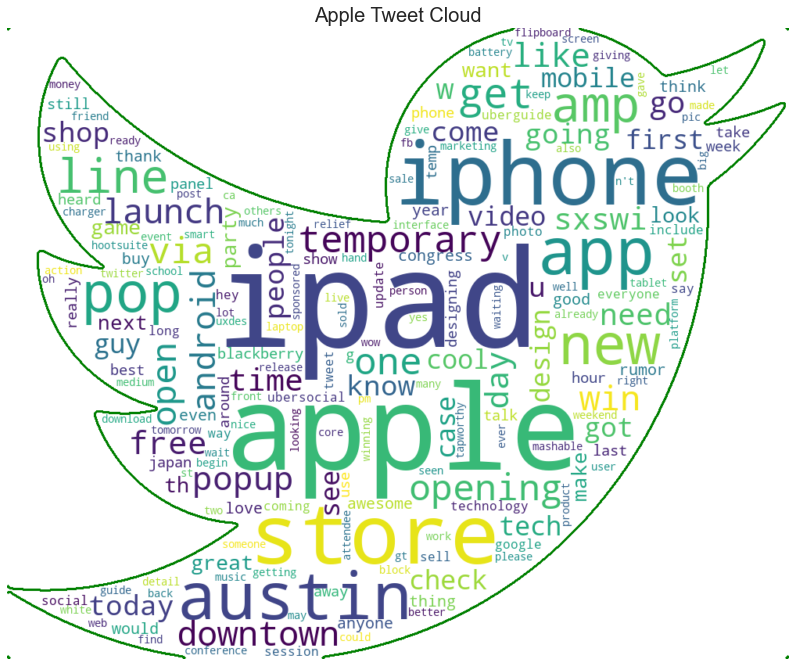

In [100]:
# generating a wordcloud with a twitter mask for positive words only 
wordcloud = WordCloud(stopwords=english_stopwords,
                      collocations=False, 
                      mask=twitter_mask, 
                      background_color='white', 
                      width=1800,
                      height=1400, 
                      contour_color='green', 
                      contour_width=2)

wordcloud.generate(','.join(apple_stopped))

plt.figure(figsize=(14, 14), 
           facecolor=None)

plt.imshow(wordcloud, 
           interpolation='bilinear')

plt.title('Apple Tweet Cloud', 
          size=20)

plt.axis("off")

plt.savefig('images/apple_tweet_cloud');

In [46]:
# creating a corpus for positive tweets only 
google = df[df.Manufacturer == "Google"]
google_corpus = google.Text.to_list()
google_corpus = ",".join(google_corpus)

In [47]:
# word tokenize and lowercase all words 
google_tokens = word_tokenize(google_corpus)
google_stopped = [token.lower() for token in google_tokens if token.lower() not in english_stopwords]

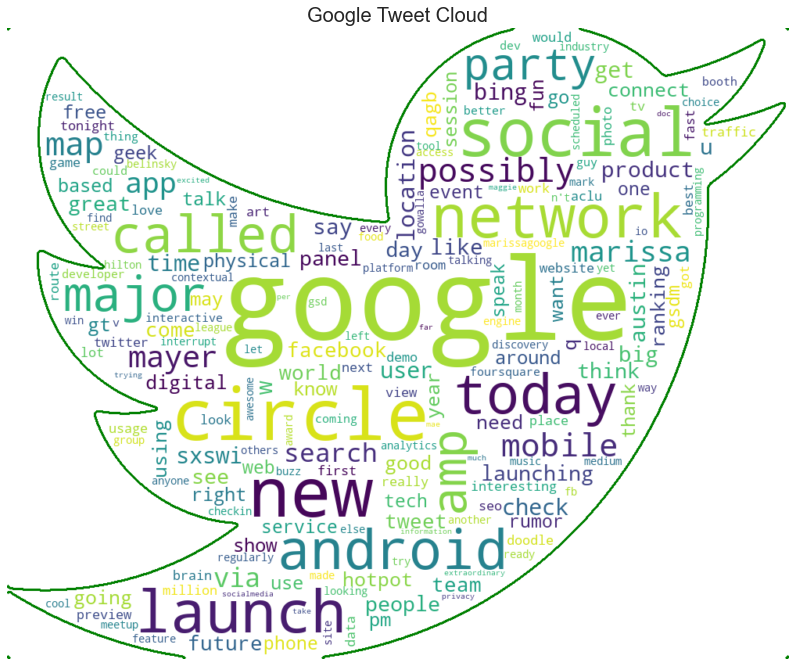

In [56]:
# generating a wordcloud with a twitter mask for positive words only 
wordcloud = WordCloud(stopwords=english_stopwords,
                      collocations=False, 
                      mask=twitter_mask, 
                      background_color='white', 
                      width=1800,
                      height=1400, 
                      contour_color='green', 
                      contour_width=2)

wordcloud.generate(','.join(google_stopped))

plt.figure(figsize=(14, 14), 
           facecolor=None)

plt.imshow(wordcloud, 
           interpolation='bilinear')

plt.title('Google Tweet Cloud', 
          size=20)

plt.axis("off")

plt.savefig('images/google_tweet_cloud');

# Train/Test Split, Label Encoding, Vectorization

In [60]:
# train test split with test size = 10% and random_state for result interpretability
X = df.Text
y = df.Sentiment

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.10, 
                                                    random_state=42, 
                                                    stratify=y)

In [61]:
# TFIDF vectorize X_train and X_test
tf_idf = TfidfVectorizer(ngram_range=(1, 2))

X_train = tf_idf.fit_transform(X_train.tolist())
X_test = tf_idf.transform(X_test.tolist())

In [62]:
# check shapes
print(X_train.shape, X_test.shape)

(8042, 41396) (894, 41396)


In [63]:
# LabelEncode
label_encoder = preprocessing.LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

In [ ]:
tokenize = df['Text'].apply(lambda x: x.split())

w2vec_model = Word2Vec(tokenize, 
                       min_count=1, 
                       size=100, 
                       window=5, 
                       sg=1)

w2vec_model.train(tokenize,
                  total_examples=len(df['Text']),
                  epochs=20)

In [ ]:
w2vec_model.most_similar('iphone')

In [ ]:
w2v_words = list(w2vec_model.wv.vocab)

print(f"number of words that occured minimum 5 times {len(w2v_words)}\n")
print(f"sample words {w2v_words[0:10]}")

In [ ]:
vector=[]

from tqdm import tqdm
for sent in tqdm(tokenize):
    sent_vec=np.zeros(100)
    count =0
    for word in sent: 
        if word in w2v_words:
            vec = w2vec_model.wv[word]
            sent_vec += vec
            count += 1
    if count != 0:
        sent_vec /= count #normalize
        vector.append(sent_vec)

print(len(vector))
print(len(vector[0])) 

In [ ]:
print(f"number of uniqe words {len(vector[1])}")

w2v_train = pd.DataFrame(vector)
w2v_train['length_tweet'] = df['length_tweet']
w2v_train['Sentiment'] = df['label']

w2v_train.head()

In [ ]:
train = df.copy()
train.drop(columns=['index','Text','preprocessed_text'],
           inplace=True)

In [ ]:
bow = CountVectorizer(min_df=2, max_features=1000)
bow.fit(df['Text'])
bow_df = bow.transform(df['Text']).toarray()

print('feature name ==', bow.get_feature_names()[:10])
print('number of uniqe words', bow_df.shape[1])
print('shape', bow_df.shape)

bow_train = pd.DataFrame(bow_df)
bow_train['length_tweet'] = df['length_tweet']
bow_train['label'] = df['label']
bow_train.head()

In [ ]:
major_class_0, major_class_1, major_class_2 = bow_train.label.value_counts()

df_1 = bow_train[bow_train['label'] == 0]
df_2 = bow_train[bow_train['label'] == 1]
df_3 = bow_train[bow_train['label'] == 2]

df_1_upsampled = resample(df_1,
                          replace=True, # Sample with replacement
                          n_samples=major_class_0)

df_bow_upsampled = pd.concat([df_1, df_2, df_3])

print('shape', df_bow_upsampled.shape)

sns.countplot(df_bow_upsampled.label, 
              palette='crest');

In [ ]:
major_class_0, major_class_1, major_class_2 = w2v_train.Sentiment.value_counts()

df_1 = w2v_train[w2v_train['Sentiment'] == 0]
df_2 = w2v_train[w2v_train['Sentiment'] == 1]
df_3 = w2v_train[w2v_train['Sentiment'] == 2]

df_1_upsampled = resample(df_1,
                          replace=True, # Sample with replacement
                          n_samples=major_class_0)

df_w2v_upsampled = pd.concat([df_1, df_2, df_3])

print('shape', df_w2v_upsampled.shape)
sns.countplot(df_w2v_upsampled.Sentiment, 
              palette='crest');

In [ ]:
X=df_w2v_upsampled.iloc[:,0:-1]
y=df_w2v_upsampled['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.10,
                                                    random_state=42)

In [ ]:
from gensim.models.word2vec import Word2Vec

In [ ]:
wordvec = []

for i in X_train:
    wordvec.append(i.split())
    
print(wordvec[:9])

In [ ]:
word_2_vec = Word2Vec(sentences=wordvec, 
                      size=100, 
                      window=5, 
                      min_count=5, 
                      workers=16)
print(word_2_vec)

In [ ]:
token = Tokenizer(1903)
token.fit_on_texts(df['Text'])
text = token.texts_to_sequences(df['Text'])
text = pad_sequences(text)
print(text[:9])

In [ ]:
keras_model = Sequential()
keras_model.add(input_shape=(1903, 1))
keras_model.add(word_2_vec.wv.get_keras_embedding(True))

keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(50, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(50, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))

keras_model.add(Conv1D(100, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(100, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))

keras_model.add(Conv1D(200, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(200, 3, activation='relu', padding='same', strides=1))
keras_model.add(GlobalMaxPool1D())
keras_model.add(Dropout(0.2))

keras_model.add(Dense(200))
keras_model.add(Activation('relu'))
keras_model.add(Dropout(0.2))

keras_model.add(Dense(2))
keras_model.add(Activation('softmax'))

keras_model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')
keras_model.fit(X_train, y_train, batch_size=16, epochs=3, validation_data=(X_test, y_test))

In [ ]:
from string import punctuation
from os import listdir
from nltk.corpus import stopwords
from pickle import dump
 
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    
    # read all text
    text = file.read()
    
    # close the file
    file.close()
    
    return text


# load all docs in a directory
def process_docs(directory, is_trian):
    documents = list()
    
    # walk through all files in the folder
    for filename in listdir(directory):

        # skip any reviews in the test set
        if is_trian and filename.startswith('cv9'):
            continue
        if not is_trian and not filename.startswith('cv9'):
            continue
        
        # create the full path of the file to open
        path = directory + '/' + filename
        
        # load the doc
        doc = load_doc(path)
        
        # clean doc
        tokens = clean_doc(doc)
        
        # add to list
        documents.append(tokens)
        
        return documents
 
# save a dataset to file
def save_dataset(dataset, filename):
    dump(dataset, open(filename, 'wb'))
    print('Saved: %s' % filename)
 
# load all training reviews
negative_docs = process_docs('txt_sentoken/neg', True)
positive_docs = process_docs('txt_sentoken/pos', True)
neutral_docs = process_docs('txt_sentoken/neu', True)
trainX = negative_docs + positive_docs + neutral_docs
trainy = [0 for _ in range(900)] + [1 for _ in range(900)]
save_dataset([trainX,trainy], 'train.pkl')
 
# load all test reviews
negative_docs = process_docs('txt_sentoken/neg', False)
positive_docs = process_docs('txt_sentoken/pos', False)
neutral_docs = process_docs('txt_sentoken/neu', False)

testX = negative_docs + positive_docs + neutral_docs
testY = [0 for _ in range(100)] + [1 for _ in range(100)]
save_dataset([testX,testY], 'test.pkl')

In [ ]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate

In [ ]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
tokenizer = create_tokenizer(df['Text'])

In [ ]:
# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])

In [ ]:
length = max_length(df['Text'])
length

In [ ]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [ ]:
trainX = encode_text(tokenizer, X_train, length)


In [ ]:
# define the model
def define_model(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)

    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)

    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    
    # merge
    merged = concatenate([flat1, flat2, flat3])

    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(1, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

    # compile
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # summarize
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    
    return model

In [ ]:
model = define_model(length, vocab_size)

In [ ]:
model.fit([trainX,trainX,trainX], array(y_train), epochs=10, batch_size=16)

In [ ]:
from tensorflow import keras
from keras import optimizers
optimizer=keras.optimizers.RMSprop(learning_rate=0.01)

from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

from keras import optimizers

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [ ]:
model.fit(trainX, y_train, epochs=10, batch_size=16)

# Models

#### Baseline Model (Dummy)

              precision    recall  f1-score   support

      Pos(+)       0.00      0.00      0.00        57
     Neutral       0.60      1.00      0.75       539
      Neg(-)       0.00      0.00      0.00       298

    accuracy                           0.60       894
   macro avg       0.20      0.33      0.25       894
weighted avg       0.36      0.60      0.45       894



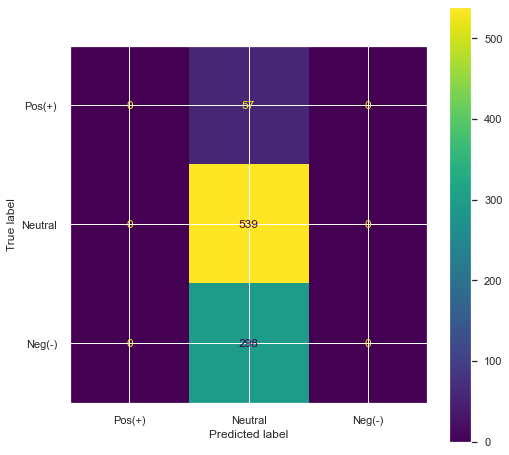

In [65]:
# Create Dummy/Baseliner
estimator = DummyClassifier(strategy='most_frequent')
estimator.fit(X_train, y_train)

# Get predictions with dummy model
y_pred = estimator.predict(X_test)

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Pos(+)', 'Neutral', 'Neg(-)']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=estimator,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_Dummy');

target_names = ['Pos(+)', 'Neutral', 'Neg(-)']
print(classification_report(y_test, y_pred, target_names=target_names))

Dummy model predicts 'Neutral' for all and has an accuracy of 60%

#### Logistic Regression with SMOTE

In [ ]:
strategy = {0:2000, 1:4200, 2:2657}

pipe = ImPipeline(steps=[
    ('sm', SMOTE(random_state=42,
                 sampling_strategy=strategy)),
    ('estimator', LogisticRegression(random_state=42))
])

param_grid = {}
param_grid['estimator__C'] = [100, 10, 1.0, 0.1, 0.01]
param_grid['estimator__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
param_grid['estimator__penalty'] = ['l2']

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=2)

# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")


# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Pos(+)', 'Neutral', 'Neg(-)']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=best_grid,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)


target_names = ['Pos(+)', 'Neutral', 'Neg(-)']
print(classification_report(y_test, y_pred, target_names=target_names))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_LogRegSMOTE');

#### Logistic without SMOTE

Fitting 30 folds for each of 15 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  2.5min finished


Mean Training Score: 79.62%

Mean Test Score: 69.91%

Optimal Parameters: {'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}

Testing Accuracy: 70.62%

              precision    recall  f1-score   support

      Pos(+)       0.61      0.25      0.35        57
     Neutral       0.74      0.81      0.77       539
      Neg(-)       0.63      0.58      0.60       298

    accuracy                           0.70       894
   macro avg       0.66      0.55      0.58       894
weighted avg       0.69      0.70      0.69       894



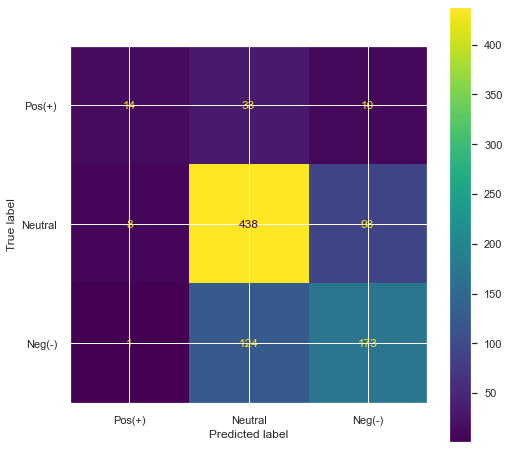

In [66]:
pipe = ImPipeline(steps=[
    ('estimator', LogisticRegression(random_state=42))
])

param_grid = {}
param_grid['estimator__C'] = [100, 10, 1.0, 0.1, 0.01]
param_grid['estimator__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
param_grid['estimator__penalty'] = ['l2']

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=2)

# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Pos(+)', 'Neutral', 'Neg(-)']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=best_grid,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)


target_names = ['Pos(+)', 'Neutral', 'Neg(-)']
print(classification_report(y_test, y_pred, target_names=target_names))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_LogReg');

Performs better on unseen data without SMOTE, we will not use SMOTE in our next models

#### Ridge Regression

Fitting 30 folds for each of 10 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.5s finished


Mean Training Score: 95.07%

Mean Test Score: 69.80%

Optimal Parameters: {'estimator__alpha': 0.8}

Testing Accuracy: 70.75%

              precision    recall  f1-score   support

      Pos(+)       0.65      0.26      0.38        57
     Neutral       0.74      0.81      0.77       539
      Neg(-)       0.62      0.57      0.59       298

    accuracy                           0.70       894
   macro avg       0.67      0.55      0.58       894
weighted avg       0.69      0.70      0.69       894



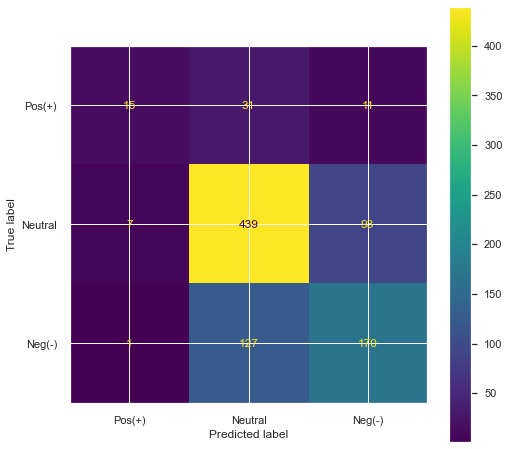

In [67]:
pipe = Pipeline(steps=[
    ('estimator', RidgeClassifier(random_state=42))
])

param_grid = {}
param_grid['estimator__alpha'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=2)

# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Pos(+)', 'Neutral', 'Neg(-)']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=best_grid,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)

target_names = ['Pos(+)', 'Neutral', 'Neg(-)']
print(classification_report(y_test, y_pred, target_names=target_names))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_Ridge');

Ridge yields a more overfit model, but it performs slightly better

#### K-Nearest Neighbors (KNN)

In [ ]:
pipe = ImPipeline(steps=[
    ('estimator', KNeighborsClassifier())])

param_grid = {}
param_grid['estimator__n_neighbors'] = [1, 5, 9, 13, 17, 21]
param_grid['estimator__metric'] = ['euclidean', 'manhattan', 'minkowski']
param_grid['estimator__weights'] = ['uniform', 'distance']
    
grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=2)

# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Pos(+)', 'Neutral', 'Neg(-)']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=best_grid,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)

target_names = ['Pos(+)', 'Neutral', 'Neg(-)']
print(classification_report(y_test, y_pred, target_names=target_names))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_KNN');

KNN not good

#### Support Vector Machine

Fitting 30 folds for each of 12 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 19.4min finished


Mean Training Score: 82.38%

Mean Test Score: 69.24%

Optimal Parameters: {'estimator__C': 1.0, 'estimator__kernel': 'linear'}

Testing Accuracy: 70.16%

              precision    recall  f1-score   support

      Pos(+)       0.67      0.18      0.28        57
     Neutral       0.72      0.84      0.78       539
      Neg(-)       0.63      0.52      0.57       298

    accuracy                           0.69       894
   macro avg       0.67      0.51      0.54       894
weighted avg       0.68      0.69      0.68       894



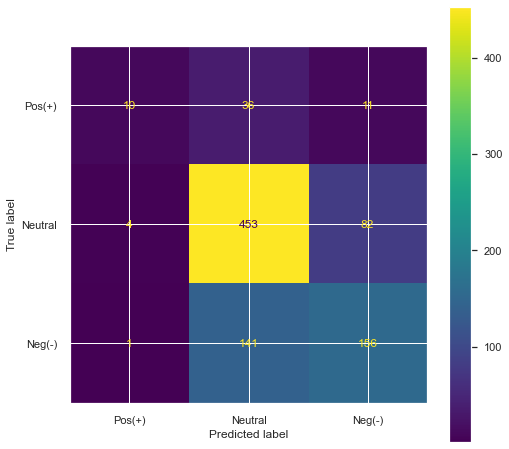

In [68]:
pipe = ImPipeline(steps=[
    ('estimator', SVC())])

param_grid = {}
param_grid['estimator__kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid['estimator__C'] = [10, 1.0, 0.1]

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=2)

# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Pos(+)', 'Neutral', 'Neg(-)']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=best_grid,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)

target_names = ['Pos(+)', 'Neutral', 'Neg(-)']
print(classification_report(y_test, y_pred, target_names=target_names))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_SVM');

#### Random Forest

In [ ]:
pipe = Pipeline(steps=[
    ('estimator', RandomForestClassifier(random_state=42))
])

param_grid = {}
param_grid['estimator__n_estimators'] = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
param_grid['estimator__max_features'] = ['auto', 'sqrt', 'log2']
param_grid['estimator__max_depth'] = [int(x) for x in np.linspace(10, 110, num=11)]
param_grid['estimator__min_samples_split'] = [2, 5, 10]
param_grid['estimator__min_samples_leaf'] = [1, 2, 4]

grid_search = RandomizedSearchCV(estimator=pipe, 
                                 param_distributions=param_grid, 
                                 cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                                 return_train_score=True, 
                                 scoring='accuracy', 
                                 n_iter=100, 
                                 random_state=42, 
                                 n_jobs=-1, 
                                 verbose=2)

# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Pos(+)', 'Neutral', 'Neg(-)']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=best_grid,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)

target_names = ['Pos(+)', 'Neutral', 'Neg(-)']
print(classification_report(y_test, y_pred, target_names=target_names))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_RandomForest');

In [ ]:
from sklearn.neural_network import MLPClassifier

pipe = Pipeline(steps=[
    ('estimator', MLPClassifier(random_state=42))
])

param_grid = {}
param_grid['estimator__learning_rate'] = ["constant", "invscaling", "adaptive"]
param_grid['estimator__hidden_layer_sizes'] = [(100,1), (100,2), (100,3)]
param_grid['estimator__alpha'] = [10.0 ** -np.arange(1, 9)]
param_grid['estimator__activation'] = ["logistic", "relu", "Tanh"]

grid_search = RandomizedSearchCV(estimator=pipe, 
                                 param_distributions=param_grid, 
                                 cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                                 return_train_score=True, 
                                 scoring='accuracy', 
                                 n_iter=100, 
                                 random_state=42, 
                                 n_jobs=-1, 
                                 verbose=2)

# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Pos(+)', 'Neutral', 'Neg(-)']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=best_grid,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)

target_names = ['Pos(+)', 'Neutral', 'Neg(-)']
print(classification_report(y_test, y_pred, target_names=target_names))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_RandomForest');